In [14]:
# where = 'kaggle'
where = 'home'

In [15]:
import gc
import os
import glob
import cv2
import torch
import librosa
import soundfile as sf
import pandas as pd
import numpy as np
import librosa.display
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold,GroupKFold
from sklearn.metrics import label_ranking_average_precision_score
from torch.utils.data import TensorDataset, DataLoader,Dataset, RandomSampler
from joblib import Parallel, delayed
from scipy.interpolate import interp1d
from IPython.display import Audio, Image
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

if where == 'kaggle':
    PATH_FLAC = '../input/rfcx-species-audio-detection/train'
    PATH_CSV = '../input/rfcx-species-audio-detection'
    PATH_NPY = './'
    
else:
    PATH_FLAC = '/home/pka/kaggle/Rainforest/notebook'
    PATH_CSV = '/home/pka/kaggle/Rainforest/input' 
    PATH_NPY = PATH_FLAC
    
torch.__version__

'1.6.0'

> **LINKS**:

* [Анализ аудиоданных с помощью глубокого обучения и Python (часть 1)](https://medium.com/nuances-of-programming/%D0%B0%D0%BD%D0%B0%D0%BB%D0%B8%D0%B7-%D0%B0%D1%83%D0%B4%D0%B8%D0%BE%D0%B4%D0%B0%D0%BD%D0%BD%D1%8B%D1%85-%D1%81-%D0%BF%D0%BE%D0%BC%D0%BE%D1%89%D1%8C%D1%8E-%D0%B3%D0%BB%D1%83%D0%B1%D0%BE%D0%BA%D0%BE%D0%B3%D0%BE-%D0%BE%D0%B1%D1%83%D1%87%D0%B5%D0%BD%D0%B8%D1%8F-%D0%B8-python-%D1%87%D0%B0%D1%81%D1%82%D1%8C-1-2056fef8525e)

* [Original, Audio Data Analysis Using Deep Learning with Python (Part 1)](https://www.kdnuggets.com/2020/02/audio-data-analysis-deep-learning-python-part-1.html)

* [Audio Data Analysis Using Deep Learning with Python (Part 2) ](https://www.kdnuggets.com/2020/02/audio-data-analysis-deep-learning-python-part-2.html)

* [Understanding Audio data, Fourier Transform](https://towardsdatascience.com/understanding-audio-data-fourier-transform-fft-spectrogram-and-speech-recognition-a4072d228520) 

* [wow](https://www.kaggle.com/c/rfcx-species-audio-detection/discussion/199619)

> **Youtube**

* [3Blue1Brown on the Fourier Transform](https://www.youtube.com/watch?v=spUNpyF58BY&feature=youtu.be)

From organizators:

> [train_tp vs. train_fp](https://www.kaggle.com/c/rfcx-species-audio-detection/discussion/197866)


# TODO

1.https://www.youtube.com/watch?v=-Yxj3yfvY-4&list=PL-wATfeyAMNqIee7cH3q1bh4QJFAaeNv0&index=15

# 1. Description



В этом соревновании вам будут предоставлены аудиофайлы, включающие звуки различных видов. Ваша задача - для каждого тестового аудиофайла предсказать вероятность того, что каждый из заданных видов будет слышен в аудиоклипе. Хотя обучающие файлы содержат как идентификацию вида, так и время, когда вид был услышан, временная локализация не является частью тестовых прогнозов.

**Обратите внимание, что данные обучения также включают в себя ложноположительные вхождения меток, чтобы облегчить обучение.**

Файлы
- train_tp.csv - данные обучения истинно положительных меток видов с соответствующей временной локализацией
- train_fp.csv - данные обучения ложных срабатываний меток видов с соответствующей временной локализацией
- sample_submission.csv - образец файла отправки в правильном формате; обратите внимание, что каждый столбец видов имеет префикс s.

- tfrecords / {train, test} - данные соревнований в формате TFRecord, который включает запись_id, audio_wav (закодирован в 16-битном формате PCM) и label_info (только для поезда), который предоставляет ограниченную строку столбцов ниже ( минус record_id), где несколько меток для record_id; -delimited.

Столбцы:
- record_id - уникальный идентификатор для записи
- Specs_id - уникальный идентификатор вида
- songtype_id - уникальный идентификатор типа песни
- t_min - начало секунды аннотированного сигнала
- f_min - нижняя частота аннотированного сигнала
- t_max - конечная секунда аннотированного сигнала
- f_max- верхняя частота аннотированного сигнала
- is_tp- [только tfrecords] индикатор того, взята ли метка из файла train_tp (1) или train_fp (0).


______
<div class ='alert alert-block alert-info'>
   
<code>Каждая строка в train_tp.csv</code> соответствует помеченному сегменту одного из обучающих аудиофайлов, который, как подтвердили эксперты, содержал разновидности_id и songtype_id.

<code>Каждая строка в train_fp.csv</code> соответствует отмеченному сегменту, который, как было проверено, не содержит видов и типа песни.
</div>

In [16]:
tp = pd.read_csv(os.path.join(PATH_CSV, 'train_tp.csv'))
fp = pd.read_csv(os.path.join(PATH_CSV, 'train_fp.csv'))
#(2880000,) частота дискретизации 48000
data, samplerate = sf.read(os.path.join(PATH_FLAC, '00204008d.flac'))
data.shape, samplerate

((2880000,), 48000)

In [17]:
Audio(os.path.join(PATH_FLAC, '00204008d.flac'))

# Waves

> **Formula wave**:
$$ y(f) =Amplitude ∗ \sin(2 ∗ \pi ∗ Frequency + phase)$$
    - phase(фаза - каково положение сигнала в нулевой момент времени)
    - frequency(Hz) количество циклов
$$f = \frac{1}{periods}$$
    - amplitude(пики от 0, hight or low)


PS: 
- big amplitude --> louder(громче)
- hight --> highter sound

**Sound power(W)** - это энергия за единицу времени, излучаемая источником звука, измеряем мощность в ваттах.

**Sound intensity(интенсивность)** - это просто мощность звука на единицу площади(W/m^2)

**Frequency modulation** - это своими словами это когда растояние между пиками одинаково а потом на какомто участке оно сужается расширяется

In [2]:
Image(url = 'https://miro.medium.com/max/700/0*QFVha2lCgyhKjhuO.gif')

# Hearing range(диапазон слышимости)

In [3]:
Image(url = 'https://lh4.googleusercontent.com/75t93EFX5wjkSRpFfvucydMbVOrIV31xjCiF4x7HbbaloHXfEwQ60cR2ClyXhy825K5yPWijk9S6Nrwv20TNtzgsBYbG3CfBmUAIucTxqlZbzKUZQyRIEdFjM5XZ0UZkNSCjvbhs')

In [4]:
Image(url = 'https://i.pinimg.com/originals/f6/9f/62/f69f628adebeb2ef3838a69f522d7bdf.jpg')

# What is sampling a sound wave

In [5]:
Image(url = 'https://i.pinimg.com/originals/09/11/9e/09119ed8b5968675a80e1ba4ec17f3df.png')

In [6]:
Image(url = 'https://cdn.shopify.com/s/files/1/0970/0050/files/Bit_Depth.png?13838648588627656730')

## Что такое дискретизация(Sampling) и частота дискретизации(Sampling frequency)?

Звуковые волны оцифровываются путем их дискретизации с дискретными интервалами(discrete intervals), известными как частота дискретизации(sampling rate)

$$\text{TIME COUNTS PERIODS} = n * T$$
    
    - T - is perid sample,
    - n = count
    
**SAMPLE_RATE = 1 / T (частота дискретизации, Гц)
указывает какое количество образцов у нас есть для каждой секунды**

PS: 
        - 1 / 441000 = 0.0227 милисек
        значения ниже 0,10 милисек мы не слышим


Высокая частота дискретизации приводит к меньшим потерям информации, но к более высоким затратам на вычисления, а низкие частоты дискретизации приводят к более высоким потерям информации, но их можно быстро и дешево вычислить.

Частота дискретизации — это количество семплов за определенный фиксированный промежуток времени.

* samplerate = 48k говорит, что этот звук был *записан (дискретизирован)* с частотой дискретизации 48k. Другими словами, при записи этого файла мы регистрировали 48000 амплитуд каждую секунду.

* Каждый семпл представляет собой амплитуду волны в определенном временном интервале, где глубина в битах (или динамический диапазон сигнала) определяет, насколько детализированным будет семпл (обычно 16 бит, т.е. семпл может варьироваться от 65 536 значений амплитуды).

Таким образом, если мы хотим узнать продолжительность звука, мы можем просто разделить количество выборок (амплитуд) на частоту дискретизации

В одной секунде 48к значений

In [ ]:
time = len(data) / samplerate
print(f'Duration audio is : {time} second')

In [ ]:
librosa.display.waveplot(y = data, sr = samplerate, color = "#B14D")
plt.ylabel('Amplitude')
plt.title('00204008d.flac')
plt.show()

# Частота Найквиста

- в цифровой обработке сигналов частота, равная половине частоты дискретизации. Названа в честь Гарри Найквиста.

Из теоремы Котельникова следует, что при дискретизации аналогового сигнала потерь информации не будет только в том случае,
если (спектральная плотность) наивысшая частота полезного сигнала равна половине или меньше частоты дискретизации
(в англоязычной литературе под обозначением половины частоты дискретизации употребляют термин частота Найквиста).
В противном случае при восстановлении аналогового сигнала будет иметь место наложение спектральных «хвостов»
(подмена частот, маскировка частот, алиасинг), и форма восстановленного сигнала будет искажена.

Поэтому частоту дискретизации выбирают с запасом, к примеру, в аудио компакт-дисках используется частота дискретизации 44100 Герц,
в то время как высшей частотой в спектре звуковых сигналов, которую может услышать человек, считается частота 20000 Гц.
Запас по частоте Найквиста в 44100 / 2 - 20000 = 2050 Гц позволяет избежать подмены частот при использовании реализуемого 
фильтра невысокого порядка.

# Quantization

In [7]:
Image(url = 'https://upload.wikimedia.org/wikipedia/commons/b/b7/3-bit_resolution_analog_comparison.png')

Квантова́ние (англ. quantization) — в обработке сигналов — разбиение диапазона отсчётных значений сигнала на конечное число уровней и округление этих значений до одного из двух ближайших к ним уровней.

Не следует путать квантование с дискретизацией (и, соответственно, шаг квантования с частотой дискретизации). При дискретизации изменяющаяся во времени величина (сигнал) замеряется с заданной частотой (частотой дискретизации), таким образом, дискретизация разбивает сигнал по временной составляющей (на графике — по горизонтали). Квантование же приводит сигнал к заданным значениям, то есть округляет сигнал до ближайших к нему уровней (на графике — по вертикали).

При оцифровке сигнала количество битов, кодирующих один уровень квантования, называют глубиной квантования или разрядностью. Чем больше глубина квантования и чем больше частота дискретизации, тем точнее цифровой сигнал соответствует аналоговому.

Разрядность квантования звука обычно выбирается равной от 8 до 32 битов (сравнение цифровых аудиоформатов), но обычно 16 или 24 бита.

# Specral leakage(спектральная утечька)

- происходит когда обрабатываем сигнал когда используем преобразование Фурье(периоды,
не являются целым числом, это происходит постоянно)
конечьные точки сигналы прерывистые(другими словами они прерывистые потому что не целое число периодов)

Эти неоднородности переводятся в спектр или частотную облясть как высокочастотные компоненты, но их как бы в действительности нет
это и есть артефакты из-за разрывов в конце сигнала.
Решить эту проблему можно это окна(мы применяем оконную функцию к каждому фрайму,hann window)

In [8]:
Image(url = 'https://www.wavemetrics.com/sites/www.wavemetrics.com/files/images-imported/fftwindowingdemo_3.png')

как видим функция сгладила концы, но теперь у нас новая проблема,мы теряем информацию.
Решение этой головоломки это перекрытие кадров

In [9]:
Image(url = 'https://i.stack.imgur.com/Jg5EG.png')

Вот хошрошо видное если мы просто наделаем кадров(frames) то приминив хан функцию мы будем терять края,
но если будем накладывать одно окно на другое мы избежим потери информации.

- frame size размер окна которое мы рассматривае для каждого кадра
- hop lenght это количечтво семплов смещения в право каждый раз когда берем новый образец

In [10]:
Image(url = 'https://www.mathworks.com/help/dsp/ref/stft_output.png')

## 1.1 Cпектрограмма(Spectrogram)

- Спектрограмма — это визуальный способ представления уровня или “громкости” сигнала во времени на различных частотах, присутствующих в форме волны. Обычно изображается в виде тепловой карты.

PS

Вы можете представить спектрограмму как набор FFT, наложенных друг на друга. Это способ визуально представить громкость или амплитуду сигнала, поскольку она меняется во времени на разных частотах.

In [ ]:
x = librosa.stft(data) # .stft() преобразует данные в кратковременное преобразование Фурье
xdb = librosa.amplitude_to_db(abs(x))
plt.figure(figsize=(14, 10))
librosa.display.specshow(xdb, sr = samplerate, x_axis = 'time', y_axis = 'log')

Но когда мы применили fft к нашему сигналу, он дал нам только значения частоты, и мы потеряли информацию о времени.
Нам нужно найти другой способ расчета характеристик нашей системы, чтобы она имела значения частоты вместе со временем, в которое они наблюдались. Здесь на сцену выходят спектрограммы.

**Визуальное представление частот данного сигнала во времени называется спектрограммой.** 

На графике представления спектрограммы - одна ось представляет время, вторая ось представляет частоты, а цвета представляют величину (амплитуду) наблюдаемой частоты в конкретный момент времени. Яркие цвета представляют сильные частоты. 

In [ ]:
"""
Идея состоит в том, чтобы разбить аудиосигнал на более мелкие кадры (окна) и вычислить DFT (или FFT) для каждого окна.
Таким образом, мы будем получать частоты для каждого окна, а номер окна будет представлять время.
Первым идет окно 1, затем окно 2… и так далее.
Это хорошая практика, чтобы эти окна перекрывали друг друга, иначе мы можем потерять несколько частот.
Размер окна зависит от решаемой проблемы.
Для типичной задачи распознавания речи рекомендуется окно длительностью от 20 до 30 мсек.
В этом временном окне человек не может произнести более одной фонемы. 
Таким образом, если окно будет намного меньше, мы не потеряем никакой фонемы при классификации. 
Перекрытие фреймов (окон) может варьироваться от 25% до 75% в зависимости от ваших потребностей,
как правило, для распознавания речи сохраняется 50%.
В нашем расчете спектрограммы мы будем сохранять длительность окна 20 мс и перекрытие между окнами 50%.
Поскольку наш сигнал дискретизируется с частотой 16k, каждое окно будет иметь (16000 * 20 * 0,001) = 320 амплитуд.
Для перекрытия 50% нам нужно продвинуться вперед на (320/2) = 160 значений амплитуды, чтобы перейти к следующему окну.
Таким образом, наша величина шага равна 160.
Посмотрите на функцию спектрограммы на следующем изображении.
В строке 18 мы создаем окно взвешивания (Ханнинга) и умножаем его на амплитуды,
прежде чем передать его функции fft в строке 20.
Окно взвешивания используется здесь для обработки разрыва этого слабого сигнала (слабый сигнал из одного кадра)
перед его передачей в алгоритм DFT. 
"""
def spectrogram(samples, sample_rate, stride_ms = 10.0, 
                          window_ms = 20.0, max_freq = None, eps = 1e-14):

    stride_size = int(0.001 * sample_rate * stride_ms)
    window_size = int(0.001 * sample_rate * window_ms)

    # Extract strided windows
    truncate_size = (len(samples) - window_size) % stride_size
    samples = samples[:len(samples) - truncate_size]
    nshape = (window_size, (len(samples) - window_size) // stride_size + 1)
    nstrides = (samples.strides[0], samples.strides[0] * stride_size)
    windows = np.lib.stride_tricks.as_strided(samples, 
                                          shape = nshape, strides = nstrides)
    
    assert np.all(windows[:, 1] == samples[stride_size:(stride_size + window_size)])

    # Window weighting, squared Fast Fourier Transform (fft), scaling
    weighting = np.hanning(window_size)[:, None]
    
    fft = np.fft.rfft(windows * weighting, axis=0)
    fft = np.absolute(fft)
    fft = fft**2
    
    scale = np.sum(weighting**2) * sample_rate
    fft[1:-1, :] *= (2.0 / scale)
    fft[(0, -1), :] /= scale
    
    # Prepare fft frequency list
    freqs = float(sample_rate) / window_size * np.arange(fft.shape[0])
    
    # Compute spectrogram feature
    ind = np.where(freqs <= max_freq)[0][-1] + 1
    specgram = np.log(fft[:ind, :] + eps)
    return specgram

In [ ]:
x = librosa.stft(data)
spgram = spectrogram(data, samplerate, stride_ms = 10.0, window_ms = 20.0, max_freq = 16000, eps = 1e-14)
plt.figure(figsize=(14, 10))
librosa.display.specshow(spgram, sr = samplerate, x_axis = 'time', y_axis = 'log')

## 1.2 Make signal

In [ ]:
sr = 16000 # sample freq or sample rate
time = 5 # 5 sec
x = np.linspace(0, time, time * sr, endpoint = False) # time
wave = 0.5* np.sin(2 * np.pi * 160 *x) # single wave 160 hz
Audio(wave, rate = sr)

Cool!! Tooooooooooooooooo

# 2. Feature extraction from Audio signal

- Спектральные (частотные) признаки получаются путем преобразования временного сигнала в частотную область с помощью преобразования Фурье. К ним относятся частота основного тона, частотные компоненты, спектральный центроид, спектральный поток, спектральная плотность, спектральный спад и т.д.

## 2.1 Spectral Centroid

In [ ]:
sc = librosa.feature.spectral_centroid(data, sr= samplerate)[0]
time = librosa.frames_to_time(range(len(sc)))
# normolize
sc -= sc.min()
sc /= sc.ptp()

plt.figure(figsize = (15, 5))
librosa.display.waveplot(data, sr = samplerate, color = 'g', alpha =.5, label = 'Song amplitude')
plt.plot(time, pd.Series(sc).rolling(window=25).mean(), color = 'r', label = 'Centroid')
plt.legend()
plt.title("Spectral Centroid(Moving average, data is Noise) compare Amplitude song");

## 2.2 Spectral Rolloff(спад)

- Это мера формы сигнала, представляющая собой частоту, в которой высокие частоты снижаются до 0.

In [ ]:
sr = librosa.feature.spectral_rolloff(data, sr = samplerate)[0]
# normolize
sr -= sr.min()
sr /= sr.ptp()
plt.figure(figsize = (15, 5))
librosa.display.waveplot(data, sr = samplerate, color = 'g', alpha =.5, label = 'Song amplitude')
plt.plot(time, pd.Series(sr).rolling(window=15).mean(), color = 'r', label = 'Centroid')

In [ ]:
sr[sr == 0]

# 2.3 Zero-Crossing Rate

- Простой способ измерения гладкости сигнала — вычисление числа пересечений нуля в пределах сегмента этого сигнала. Голосовой сигнал колеблется медленно. Например, сигнал 100 Гц будет пересекать ноль 100 раз в секунду, тогда как “немой” фрикативный сигнал может иметь 3000 пересечений нуля в секунду.

In [ ]:
start, stop = 7000,9100
zero_crossing = librosa.zero_crossings(data[start:stop], pad = False) # return bool mask
print('Count zero_crossings: ', sum(zero_crossing))
librosa.display.waveplot(data[start:stop][zero_crossing], sr = samplerate);

## 2.4 Мел-частотные кепстральные коэффициенты (MFCC)(Mel-Frequency Cepstral Coefficients(MFCCs))

- Представляют собой небольшой набор признаков (обычно около 10–20), которые кратко описывают общую форму спектральной огибающей. Они моделируют характеристики человеческого голоса.

In [ ]:
mfccs = librosa.feature.mfcc(data, sr = samplerate)
print(mfccs.shape)
librosa.display.specshow(mfccs, sr= samplerate, x_axis = 'time')

## 2.5 Mel Spectrogram

Шкала Мела

Исследования показали, что люди не воспринимают частоты в линейном масштабе. Мы лучше обнаруживаем различия на низких частотах, чем на высоких. Например, мы можем легко определить разницу между 500 и 1000 Гц, но вряд ли сможем отличить между 10 000 и 10 500 Гц, даже если расстояние между двумя парами одинаковое.

В 1937 году Стивенс, Фолькманн и Ньюманн предложили такую единицу высоты тона, чтобы равные расстояния по высоте звучали одинаково далеко для слушателя. Это называется шкалой мела. Мы выполняем математическую операцию с частотами, чтобы преобразовать их в мел-шкалу.

**Спектрограмма mel** - это спектрограмма, в которой частоты преобразованы в шкалу mel.

1. Extrac STFT
2. Convert to DFs
3. To Mel scale

N_mel = 40, 60, 90, 128 it depends on the problem(need test its **hyperparameter**)
*кол-во похожих групп*

mel_spectigram = (bands, frames)


In [51]:
bank_filter = librosa.filters.mel(n_fft=2048,
                                  sr = 48000,
                                  n_mels = 10)
bank_filter.shape # (n_mels, 2048/2 = frame freq)

(10, 1025)

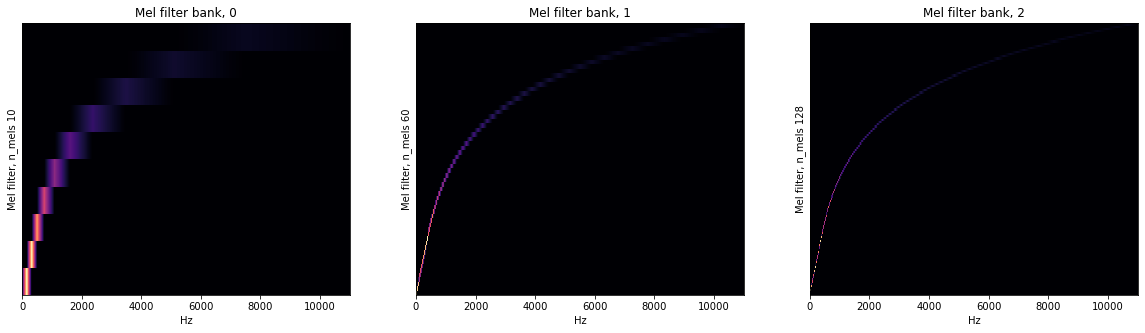

In [63]:
fig, ax = plt.subplots(1,3, figsize = (20, 5))
temp_mel = [10, 60, 128]
for i in range(3):
    bank_filter = librosa.filters.mel(n_fft=2048,
                                  sr = 48000,
                                  n_mels = temp_mel[i])
    img = librosa.display.specshow(bank_filter, x_axis='linear', ax=ax[i])
    ax[i].set(ylabel = f'Mel filter, n_mels {temp_mel[i]}', title = f'Mel filter bank, {i}')

# n_mels its Y_label !!!!

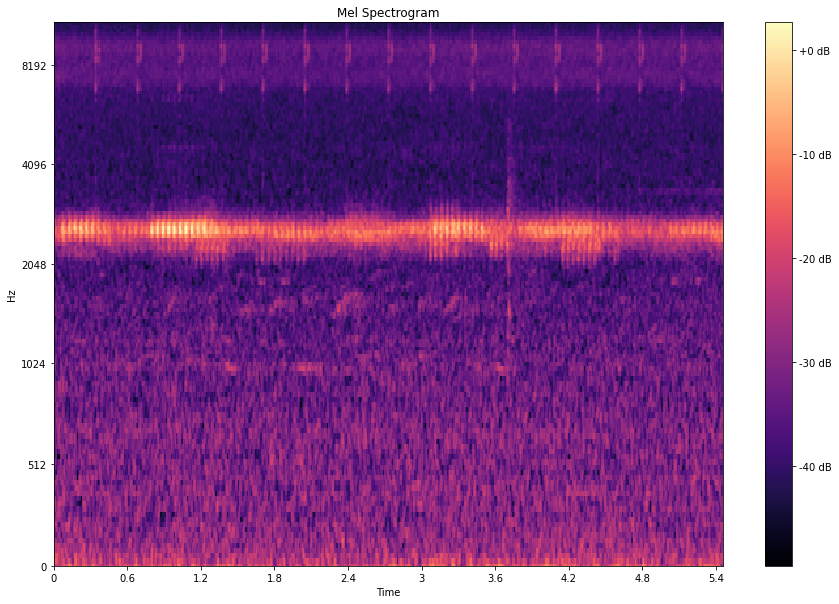

In [45]:
"""
n_ff int > 0 [скаляр] длина оконного сигнала после заполнения нулями. 
                    (1 + n_fft / 2). Значение по умолчанию, n_fft = 2048 выборок, 
                    частоте дискретизации 22050 Гц, то есть частоте дискретизации по умолчанию в librosa.
                    Это значение хорошо адаптировано для музыкальных сигналов.
                    Однако при обработке речи рекомендуемое значение составляет 512, что соответствует 23 миллисекундам 
                    при частоте дискретизации 22050 Гц. 
                    В любом случае мы рекомендуем устанавливать n_fft в степень двойки для оптимизации скорости
                    алгоритма быстрого преобразования Фурье.

Меньшие значения улучшают временное разрешение STFT 
(то есть способность различать импульсы, которые близко расположены во времени) 
за счет разрешения по частоте (то есть способности различать чистые тона, которые близко расположены по частоте).
Этот эффект известен как компромисс локализации времени и частоты,
и его необходимо регулировать в соответствии со свойствами входного сигнала y.


fmin lowest frequency (in Hz)
fmax highest frequency (in Hz). If None, use fmax = sr / 2.0
"""


mel_spect = librosa.feature.melspectrogram(data, sr=samplerate, n_mels = 128, fmin=20, fmax=samplerate//2)
mel_spect = librosa.power_to_db(mel_spect)
plt.figure(figsize = (15, 10))
librosa.display.specshow(mel_spect[:, :512], sr = samplerate, y_axis='mel', x_axis='time');
plt.title('Mel Spectrogram');
plt.colorbar(format='%+2.0f dB');

При вычислении STFT вы вычисляете FFT для ряда коротких сегментов. Эти отрезки имеют длину n_fft. Обычно эти сегменты перекрываются (во избежание потери информации), поэтому расстояние между двумя сегментами часто не n_fft, а что-то вроде n_fft / 2. Имя для этого расстояния - длина_хопа. Это также определяется в образцах.

Итак, когда у вас есть 1000 аудиосэмплов, а hop_length равно 100, вы получаете 10 кадров функций (обратите внимание, что если n_fft больше, чем hop_length, вам может потребоваться заполнение).

В вашем примере вы используете значение hop_length по умолчанию, равное 512. Таким образом, для звука с частотой дискретизации 22050 Гц вы получаете частоту кадров функции

frame_rate = sample_rate / hop_length = 22050 Гц / 512 = 43 Гц
Опять же, отступы могут немного изменить это.

Таким образом, для 10 секунд звука с частотой 22050 Гц вы получаете массив спектрограмм с размерами (128, 430), где 128 - количество бункеров Mel, а 430 - количество функций (в данном случае спектры Mel).

In [46]:
print('Shape mel: ', mel_spect.shape)
print('Hz: ', samplerate / 512)
print('Seconds: ', 5626/93.75)

Shape mel:  (128, 5626)
Hz:  93.75
Seconds:  60.010666666666665


## 2.5 Root-Mean Square Energy (RMSE)

Вычислите среднеквадратичную (RMS) энергию для каждого кадра либо из аудиосэмплов y, либо из спектрограммы S.

Вычисление энергии из аудиосэмплов происходит быстрее, поскольку не требует вычисления STFT. Однако использование спектрограммы даст более точное представление энергии во времени, потому что ее кадры могут быть разделены на окна, поэтому предпочтительнее использовать S, если он уже доступен.

In [ ]:
# librosa.feature.rmse(y=None, S=None, frame_length=2048, hop_length=512, center=True, pad_mode=’reflect’)
frame_len = 1024
hope = 512
rms = librosa.feature.rms(data) # (1, 5626)
rms2 = librosa.feature.rms(data, frame_length = frame_len, hop_length = hope)

t = librosa.frames_to_time(range(len(rms[0])), hop_length = hope)
plt.figure(figsize = (15, 10))
ax = plt.subplot(2,1,1)
librosa.display.waveplot(data, alpha =.5)
ax.plot(t, rms[0], color = 'r')
plt.title('RMS, two graph with default param')

t = librosa.frames_to_time(range(len(rms2[0])), hop_length = hope)
ax = plt.subplot(2,1,2)
librosa.display.waveplot(data, alpha =.5)
ax.plot(t, rms2[0], color = 'r')
plt.title('RMS, two graph with param: frame = 1024, hope = 512')
plt.show()

In [ ]:
# https://librosa.org/doc/main/feature.html

# 3 Fourier Transform

Громкость (амплитуда) звуковой волны, изменяющуюся во времени. Амплитуда = 0 означает тишину. (Из определения звуковых волн - эта амплитуда на самом деле представляет собой амплитуду частиц воздуха, которые колеблются из-за изменения давления в атмосфере из-за звука).
Эти амплитуды не очень информативны, так как говорят только о громкости записи звука. Чтобы лучше понять звуковой сигнал, необходимо преобразовать его в частотную область.

*Представление сигнала в частотной области сообщает нам, какие разные частоты присутствуют в сигнале.*

**Преобразование Фурье - это математическая концепция, которая может преобразовывать непрерывный сигнал из временной области в частотную.**

**Аудиосигнал** - это сложный сигнал, состоящий из нескольких «одночастотных звуковых волн», которые распространяются вместе как возмущение (изменение давления) в среде.

Когда звук записывается, мы фиксируем только результирующие амплитуды этих множественных волн.

In [5]:
Image(url = 'https://miro.medium.com/max/700/1*e-_z80BnbHWyFTfRLblJ_w.gif')

**Простая синусоида для понимания FFT**

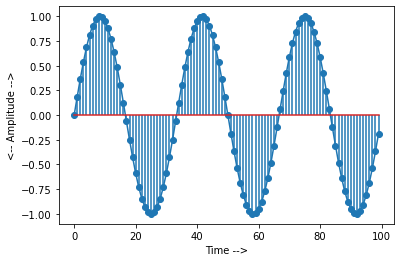

In [6]:
"""
Чтобы понять результат FFT, давайте создадим простую синусоиду.
Следующий фрагмент кода создает синусоидальную волну 
с частотой дискретизации = 100, амплитудой = 1 и частотой = 3
(sampling rate = 100, amplitude = 1 and frequency = 3).

Значения амплитуды вычисляются каждые 1/100 секунды (частота дискретизации)(1/100th second (sampling rate)) 
и сохраняются в списке с именем y1.
"""


samples = 100
f = 3
x = np.arange(samples)
y1 = np.sin(2 * np.pi * f * (x/samples))
plt.plot(x, y1)
plt.stem(x, y1, use_line_collection=True) # warning
plt.xlabel('Time -->')
plt.ylabel('<-- Amplitude -->')
plt.show()

Теперь у нас есть последовательность амплитуд, хранящаяся в списке y1. Мы передадим эту последовательность алгоритму FFT, реализованному scipy. Этот алгоритм возвращает список yf комплексных амплитуд частот(complex-valued amplitudes of the frequencies), обнаруженных в сигнале.

*Первая половина этого списка возвращает термины с положительной частотой, а другая половина возвращает термины с отрицательной частотой, которые аналогичны положительным.*

Вы можете выбрать любую половину и вычислить абсолютные значения для представления частот, присутствующих в сигнале. Следующая функция берет образцы в качестве входных данных и строит график частоты

In [7]:
# first half of this list returns positive-frequency-terms
# make first part
def wave(sample:int, freq: int)->np.array:
    x = np.arange(sample)
    y = np.sin(2 * np.pi * freq * (x/sample))
    plt.plot(x, y)
    plt.stem(x, y, use_line_collection=True) # warning
    plt.xlabel('Time -->')
    plt.ylabel('<-- Amplitude -->')   
    return x, y
    
def show_magnitude(sample:int, y:np.array)->None:
    yttf = np.fft.fft(y)  
    x = np.linspace(0.0, sample/2)   
    plt.plot(x, 2/sample * np.abs(yttf[:int(sample/2)]))
    plt.xlabel('Frequence')
    plt.ylabel('Magnitude')

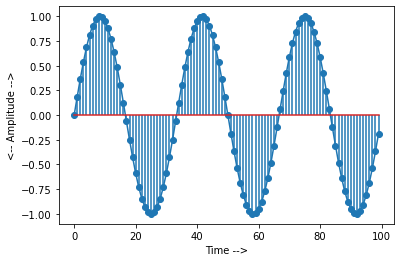

In [8]:
samples = 100
f = 3
x, y = wave(samples, f)

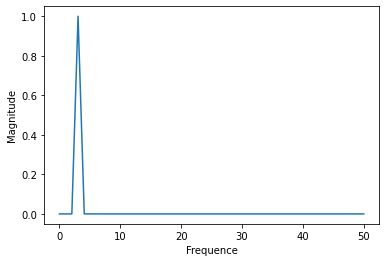

In [9]:
show_magnitude(samples, y)

мы видим максимальную амплитуду которая есть в данных(они у нас одинаковые поэтому мы видим один пик и его величину)

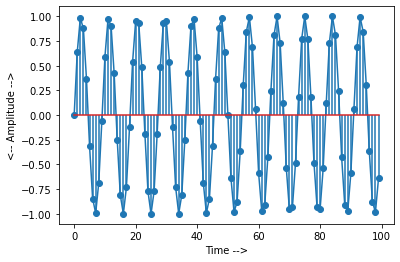

In [10]:
samples = 100
f = 11
x, y2 = wave(samples, f)

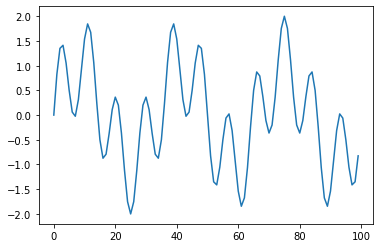

In [11]:
y3= y1 + y2
plt.plot(x, y3)

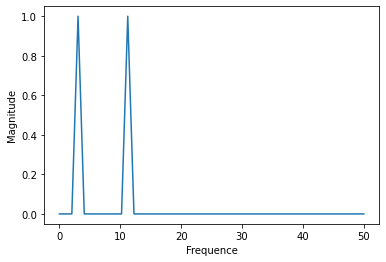

In [12]:
show_magnitude(samples, y3)

Таким образом, наличие одной частоты не влияет на другую частоту в сигнале.

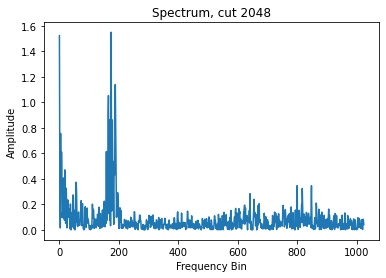

In [13]:
"""
STFT представляет сигнал в частотно-временной области путем вычисления дискретных преобразований Фурье
(FFT) в коротких перекрывающихся окнах.

The default value, n_fft=2048
"""
n_fft = 2048
ft = np.abs(librosa.stft(data[:n_fft], hop_length = n_fft+1))
plt.plot(ft);
plt.title(f'Spectrum, cut {n_fft}');
plt.xlabel('Frequency Bin');
plt.ylabel('Amplitude');

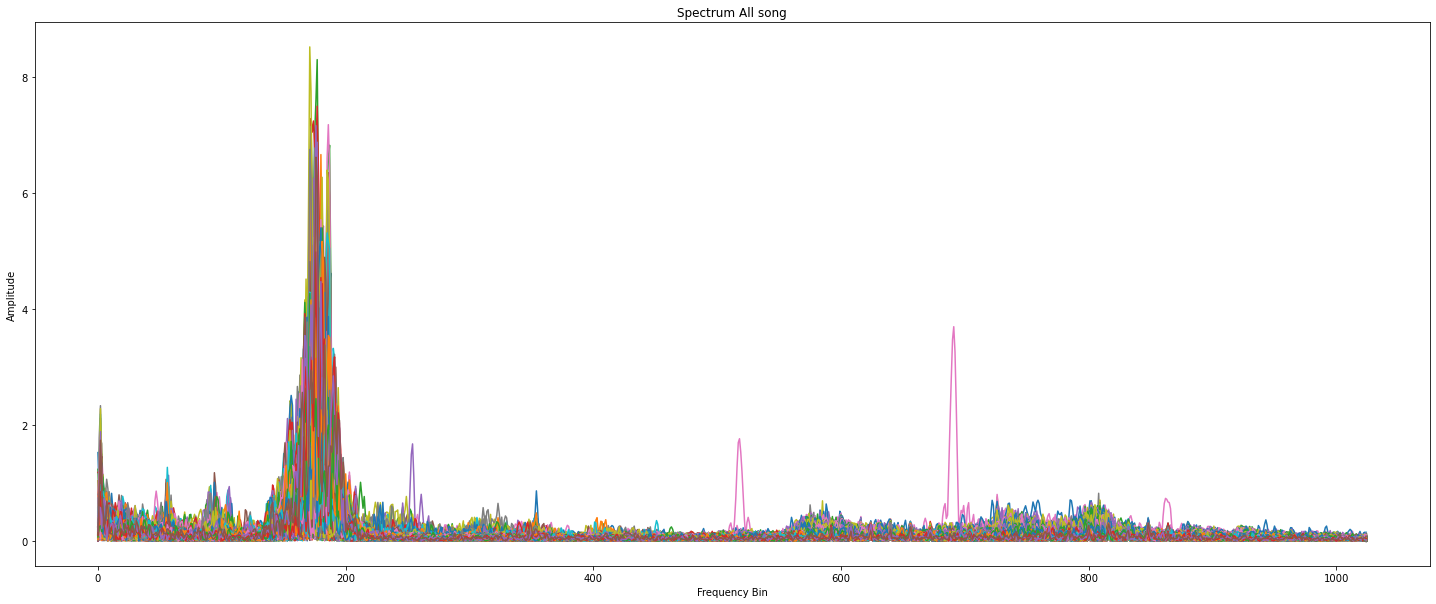

In [14]:
plt.figure(figsize = (25, 10))
ft = np.abs(librosa.stft(data, hop_length = n_fft+1))
plt.plot(ft);
plt.title('Spectrum All song');
plt.xlabel('Frequency Bin');
plt.ylabel('Amplitude');

## 3.1 STFT

Вы можете подумать: «Эй, а нельзя ли вычислить несколько спектров, выполнив fft для нескольких оконных сегментов сигнала?» Да! Именно это и делается, и это называется кратковременным преобразованием Фурье. fft вычисляется для перекрывающихся оконных сегментов сигнала, и мы получаем то, что называется спектрограммой.

Как видим чуть выше преобразование фурье ко всему файлу дает нам статичную картинку 
(усредняя частоты в ней по всей длительности сигнала). 

Но у нас теперь есть проблема мы знаем частотные состовляющие присутствуют в сигнале,
но мы не знаем когда они больше или меньше тк они все усредняются и мы не понимаем, как наш звук изменяется во времени.

**Кратковременное преобразование Фурье это переход от неподвижного изображения к изображенрию в котором учтено время.**

librosa
 - stft(y, n_fft=2048, hop_length=None, win_length=None, window='hann', center=True, dtype=None, pad_mode='reflect')
    STFT представляет сигнал в частотно-временной области путем вычисления дискретных преобразований Фурье 
    в коротких перекрывающихся окнах.
    
PARAM:

    frame_size = 512, 1024, 2048, 4096...
        - frame_size is up, freq_resolution up but time resolution down
        - frame_size is down(small), freq_resolution down but time resolution up

    hop_size   = 256,  512, 1024, 2048... frame_size/2
    window_function - 90% time used 'hann'
   
frequency_bins(сколько данных будет в окне) = framesize / 2 + 1(not nid mirror side)

fraame(window) = (samples - framesize)/hopsize + 1 

STFT = (frequency_bins, fraame(window))

In [24]:
frame_size = 2048
hop = 512
s = librosa.stft(data, n_fft= frame_size, hop_length = hop)
s.shape, type(s[0][0])

(1025, 5626)

In [30]:
#make spectogram
s_scale = np.abs(s) ** 2
type(s_scale[0][0])

numpy.float64

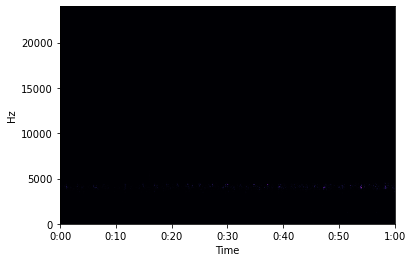

In [35]:
librosa.display.specshow(s_scale, sr = samplerate, hop_length = hop, x_axis = 'time', y_axis = 'linear')

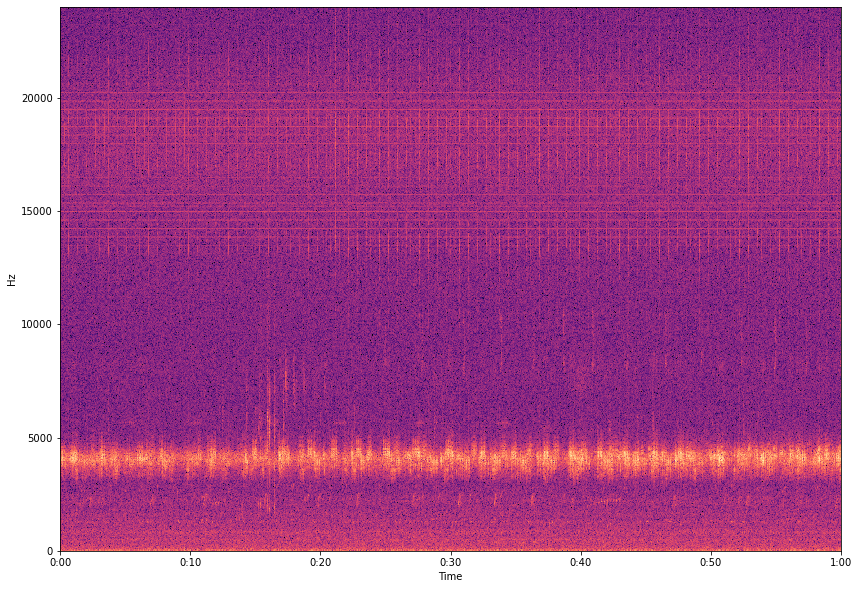

In [41]:
"""
Преобразуйте спектрограмму мощности (квадрат амплитуды) в единицы децибел (дБ)
This computes the scaling 10 * log10(S / ref) in a numerically stable way.
"""
plt.figure(figsize=(14, 10))
librosa.display.specshow(librosa.power_to_db(s_scale, ref=np.max),
                         sr = samplerate,
                         hop_length = hop,
                         x_axis = 'time',
                         y_axis = 'linear')

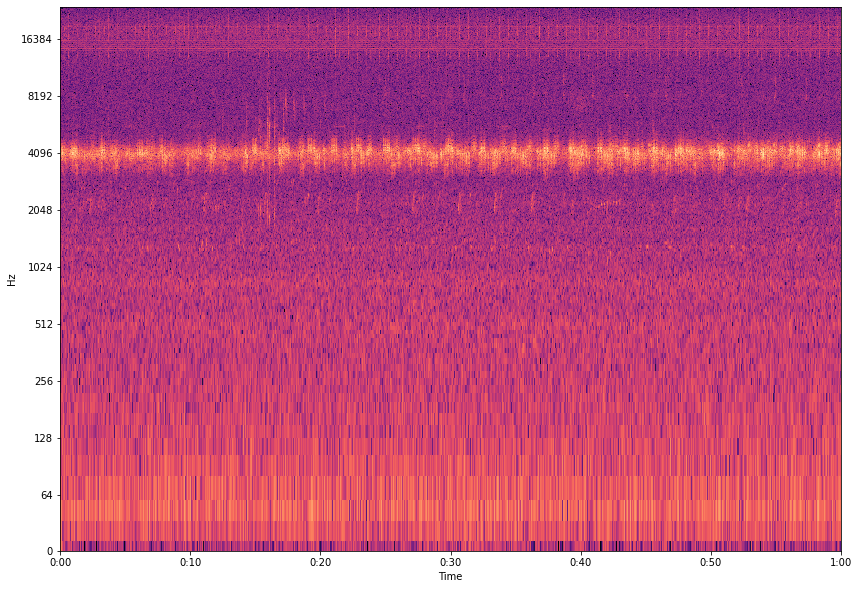

In [44]:
plt.figure(figsize=(14, 10))
librosa.display.specshow(librosa.power_to_db(s_scale, ),
                         sr = samplerate,
                         hop_length = hop,
                         x_axis = 'time',
                         y_axis = 'log')

## 3.2 See dif original and transform data

/opt/conda/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


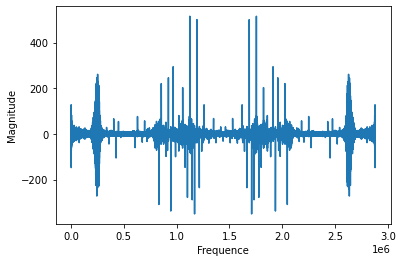

In [22]:
x = np.arange(len(data))
y1 = np.fft.fft(data)
plt.plot(x, y1)
plt.xlabel('Frequence')
plt.ylabel('Magnitude')
plt.show()

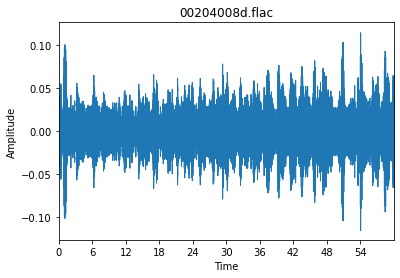

In [16]:
librosa.display.waveplot(y = data, sr = samplerate)
plt.ylabel('Amplitude')
plt.title('00204008d.flac')
plt.show()

# 4 EDA

In [11]:
import seaborn as sns

In [18]:
tp['tp'] = 1
fp['fp'] = -1
df = pd.concat([tp, fp])
fp.head()

recording_id  species_id  songtype_id    t_min       f_min    t_max  \
0    00204008d          21            1  13.8400   3281.2500  14.9333   
1    00204008d           8            1  24.4960   3750.0000  28.6187   
2    00204008d           4            1  15.0027   2343.7500  16.8587   
3    003b04435          22            1  43.2533  10687.5000  44.8587   
4    003b04435          23            1   9.1254   7235.1562  15.2091   

        f_max  fp  
0   4125.0000  -1  
1   5531.2500  -1  
2   4218.7500  -1  
3  13687.5000  -1  
4  11283.3984  -1

/home/pka/.local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


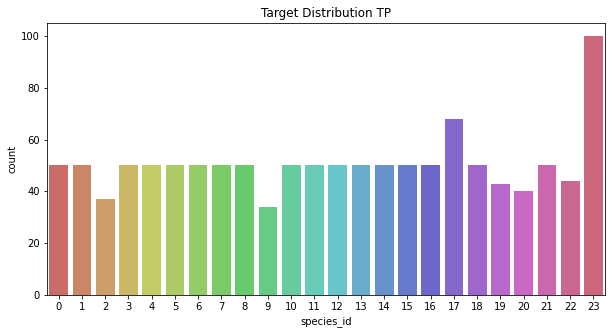

In [19]:
plt.figure(figsize = (10, 5))
sns.countplot(tp.species_id, palette = 'hls')
plt.title('Target Distribution TP');

/home/pka/.local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/pka/.local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


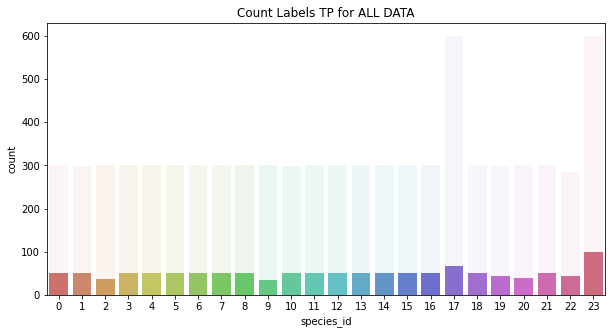

In [20]:
plt.figure(figsize = (10, 5))
sns.countplot(tp.species_id, palette = 'hls')
sns.countplot(fp.species_id,  alpha = .1)
plt.title('Count Labels TP for ALL DATA');

/home/pka/.local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/pka/.local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


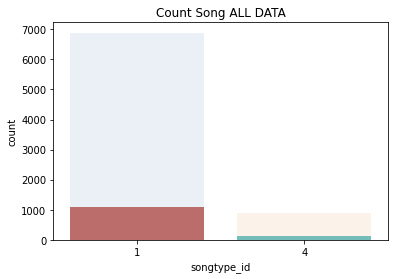

In [21]:
sns.countplot(tp.songtype_id, palette = 'hls')
sns.countplot(fp.songtype_id, alpha =.1)
plt.title('Count Song ALL DATA');

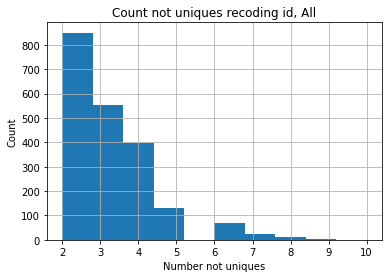

In [22]:
u_count = df.recording_id.value_counts()
u_count[u_count > 1].hist()
plt.ylabel('Count')
plt.xlabel('Number not uniques')
plt.title('Count not uniques recoding id, All');

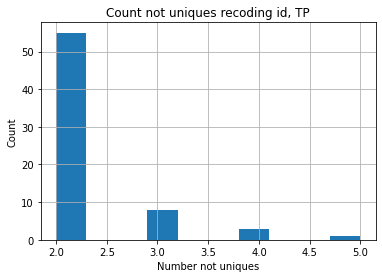

In [23]:
u_count = tp.recording_id.value_counts()
u_count[u_count > 1].hist()
plt.ylabel('Count')
plt.xlabel('Number not uniques')
plt.title('Count not uniques recoding id, TP');

<AxesSubplot:>

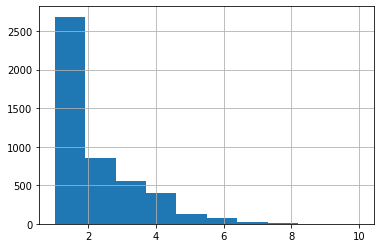

In [24]:
df.groupby('recording_id')['species_id'].count().hist()

# 5 Work with data

In [25]:
# for first sample only
# time current flac file is 60 sec but in dataframe we see interval for song
# and we resample flac data to param song
time = np.arange(data.shape[0]) / samplerate
mmin, mmax = fp.iloc[0].t_min, fp.iloc[0].t_max
# resample 52479, 2% of data
ch_data = data[np.where((time >= mmin) & (time <= mmax))]
# fourier transform
fft = np.abs(np.fft.fft(ch_data)[:len(data) // 2])
"""
привели данные к размеру tmin tmax 
мы преобразовали данны фурье
делаем для каждого 1000 признаков
размер а
преобразование b
функци f
берем данные н-размера передаем в функцию и оно будет интерполировать данные из преобразования b

a = np.arange(10)
b = np.exp(a/2)
f = interp1d(a, b)
c = np.arange(0, 10, 1)
f(c)
>> array([ 1.        ,  1.64872127,  2.71828183,  4.48168907,  7.3890561 ,
          12.18249396, 20.08553692, 33.11545196, 54.59815003, 90.0171313 
         ])
"""
# idia make data from fft 1000 features
x = np.linspace(0, len(fft), len(fft), endpoint = True)
interp = interp1d(x, fft, kind = 'cubic')
# make blank array
x = np.linspace(0, len(fft), num = 1000)
# make
fitx = interp(x)

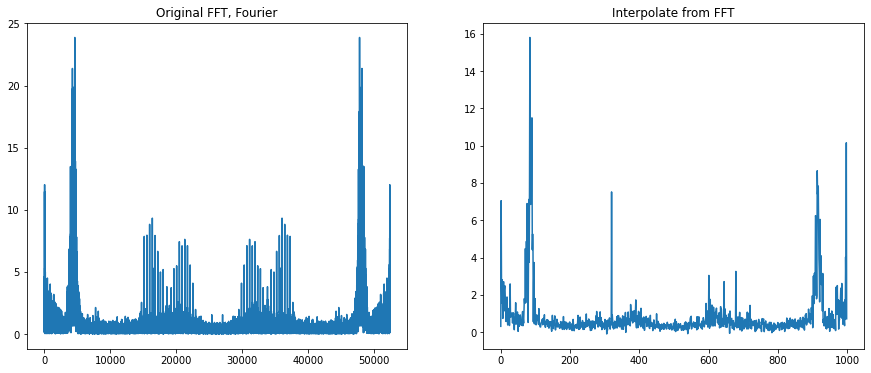

In [26]:
fig,ax = plt.subplots(1,2, figsize = (15, 6))
ax[0].plot(fft)
ax[1].plot(fitx)
ax[0].title.set_text('Original FFT, Fourier')
ax[1].title.set_text('Interpolate from FFT')


# 6 First model baseline

In [ ]:
def make_data(name: str, df: pd.DataFrame, idx:int, num:int = 1000, cut:bool = True)-> np.array:
    """
    name == recording_id == flac
    data = (tp, fp)
    idx = index in dataframe if nounique
    """
  
    data, samplerate = sf.read( '../input/rfcx-species-audio-detection/train/'+name+'.flac')
    cur_data = df[df.recording_id == name] # df    
    tmin = cur_data.iloc[idx].t_min
    tmax =cur_data.iloc[idx].t_max
#     print(name, idx)
    out_val = extract_features(data, samplerate, tmin, tmax, num =num, cut = cut)
    return out_val  
    
def extract_features(data:np.array, samplerate: int, tmin: float, tmax: float, num: int, cut:bool)->np.array: 
    """
    data = array flac
    samplerate from flac
    tmin: min time start song
    tmax: max time end song
    num : count new features   
    
    """
    if cut:
        time = np.arange(data.shape[0]) / samplerate
        ch_data = data[np.where((time >= tmin) & (time <= tmax))]
    else:
        ch_data = data
    fft = np.abs(np.fft.fft(ch_data)[:(len(ch_data) // 2)]) # add (len)
    x = np.linspace(0, len(fft), len(fft), endpoint = True)
    interp = interp1d(x, fft, kind = 'cubic')
    x = np.linspace(0, len(fft), num = num)
    fitx = interp(x)
    return fitx

In [ ]:
# temp_tp,temp_idx = [],[]
# # target = []
# check = {}
# current_data = tp.copy()
# for name in tqdm(current_data.recording_id.values):
#     if name in temp_idx:
#         idx = sum(pd.Series(temp_idx) ==  name)
#     else:
#         idx = 0
# #     if idx != 0:
# #         check[name] = idx
#     temp_idx.append(name)
#     out = make_data(name, current_data, idx, 1000, True)
#     temp_tp.append(out)
# #     target.append(current_data[current_data.recording_id == name].species_id.values[0])

# """
# a = [1,2,3]
# b = [10, 12, 13]
# np.stack((a, b))

# > array([[ 1,  2,  3],
#        [10, 12, 13]])

# """
# temp_tp = np.stack(temp_tp)

# temp_fp,temp_idx = [],[]
# target = []
# # change data
# current_data = fp.copy()
# for name in tqdm(current_data.recording_id.values):
#     if name in temp_idx:
#         idx = sum(pd.Series(temp_idx) ==  name)
#     else:
#         idx = 0  
#     temp_idx.append(name)
#     out = make_data(name, current_data, idx, 1000, False)
#     temp_fp.append(out) 
    
# temp_fp = np.stack(temp_fp)
# print(temp_fp.shape, temp_tp.shape)

# # merge tp and fp
# full_train = np.vstack((temp_tp, temp_fp))
# full_train.shape

In [ ]:
# # target 

# tt = tp[['recording_id','species_id']].copy()
# tf = fp[['recording_id','species_id']].copy()

# tf['species_id'] = -1

# label = pd.concat( (tt, tf) )

# for i in range(24):
#     label['s'+str(i)] = 0
#     label.loc[label.species_id==i,'s'+str(i)] = 1

# label.shape

In [ ]:
# # make test data
# def extract_features( fn ):
#     data, samplerate = sf.read(fn)

#     varfft = np.abs( np.fft.fft(data)[:(len(data)//2)] )
#     x = np.linspace(0, len(varfft), num=len(varfft), endpoint=True)
#     f1 = interp1d(x, varfft, kind='cubic')
#     x = np.linspace(0, len(varfft), num=1000, endpoint=True)
#     varfft = f1(x)
    
#     return varfft

# testfiles = glob.glob( '../input/rfcx-species-audio-detection/test/*.flac' )

# test = Parallel(n_jobs=-1)(delayed(extract_features)(fn) for fn in tqdm(testfiles))
# test = np.stack(test)
# test.shape

In [ ]:
# std = StandardScaler()
# std.fit(np.vstack((full_train,test)) )

# full_train = std.transform(full_train)
# test  = std.transform(test)
# gc.collect()

In [ ]:

# sub = pd.DataFrame({'recording_id': [f.split('/')[-1].split('.')[0] for f in testfiles] })
# gkf = GroupKFold(5) # default 5
# groups = label['recording_id'].values

# # loop all target
# for i in range(24):
#     target = label['s'+str(i)].values
#     tr_zeros = np.zeros(full_train.shape[0])
#     ts_zeros = np.zeros(test.shape[0])
#     for ind_tr, ind_val in gkf.split(full_train, target, groups):
#         model = LogisticRegression(C=1, max_iter=5000 )
#         model.fit(full_train[ind_tr], target[ind_tr])
        
#         tr_zeros[ind_val] = model.predict_proba(full_train[ind_val])[:,1]
#         ts_zeros += model.predict_proba(test)[:,1] / 5.

#     print( 'Target AUC', i, roc_auc_score(target, tr_zeros) )
#     label['y'+str(i)] = tr_zeros
#     sub['s'+str(i)] = ts_zeros
    
    

# sub.to_csv('submission_notcutfp.csv', index=False)
# sub.head()

# 7 Spectrogram Generationfor NN

In [27]:
def gen_mel_img(sample_rate: int, recording_id: str, path_save: str)->None:
    """
    make img: Mel Spectrogram
    and  save npy
    
    data: array song
    sr: sample rate
    
    default param: n_mels = 128, fmin=20, fmax=samplerate//2        
    """
    
    data, _ = sf.read(os.path.join(PATH_FLAC, recording_id +'.flac'))
    mel_spect = librosa.feature.melspectrogram(data, sample_rate, n_mels = 128, fmin=20, fmax=sample_rate//2)
    mel_spect = librosa.power_to_db(mel_spect)    
    np.save(os.path.join(path_save, f'{recording_id}.npy'), mel_spect)

In [28]:
gen_mel_img(16000, '00204008d', PATH_NPY)

In [29]:
img = np.load(os.path.join(PATH_NPY, '00204008d.npy'))
img.shape

(128, 5626)

/home/pka/.local/lib/python3.8/site-packages/librosa/display.py:974: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)
/home/pka/.local/lib/python3.8/site-packages/librosa/display.py:974: MatplotlibDeprecationWarning: The 'linthreshy' parameter of __init__() has been renamed 'linthresh' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)


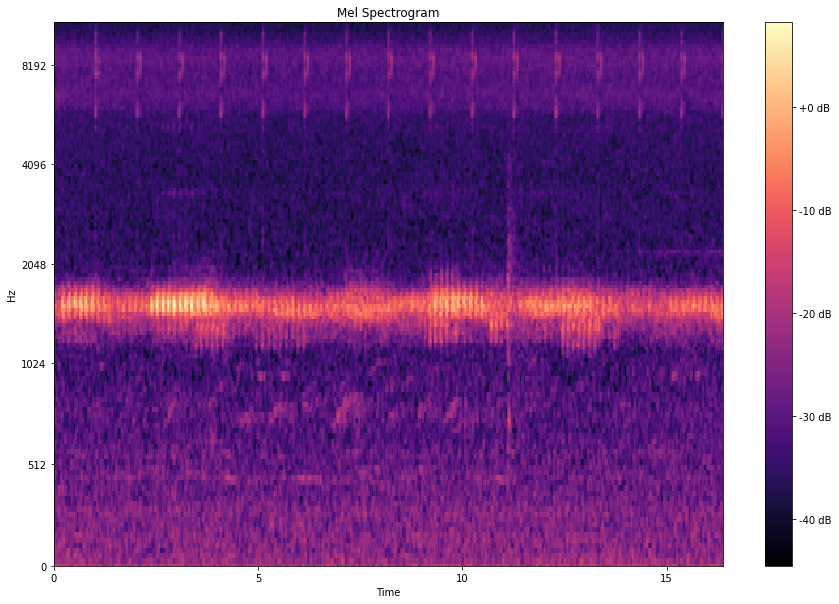

In [30]:
plt.figure(figsize = (15, 10))
librosa.display.specshow(img[:, :512], sr = 16000, y_axis='mel', x_axis='time');
plt.title('Mel Spectrogram');
plt.colorbar(format='%+2.0f dB');

# 8 First NN model 

In [ ]:
"""
no need change path to local run only kaggle for test
"""

PATH_NPY = '../input/rcfx-spectrograms-32-khz/train/'
PATH_MODEL = '../input/test-model-rainforest'
SAMPLERATE = 32000
batch_size = 32
n_workers = 4
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
epoch = 10
# loads data
tp = pd.read_csv('../input/rfcx-species-audio-detection/train_tp.csv')
fp = pd.read_csv('../input/rfcx-species-audio-detection/train_fp.csv')
df = pd.concat((tp, fp))
df = df.sample(frac = 1).reset_index(drop=True)

## 8.1 Folds

> **Idea folds**

1. ~~Uniques:~~
    ~~find count un uiques mark and group by them~~
2. ~~Group by recording_id and target , unbalance~~
3. Diff f_max&min, try 32 variant cool!
4. by target

> Cool idea make stratificate by uniques(in group array([1,  2,  3,  4,  5,  6,  7,  8,  9, 10]) will be in folds)
PS and 'Group by recording_id and target' we check by strat.

In [ ]:
# target 
tt = tp[['recording_id','species_id']].copy()
tf = fp[['recording_id','species_id']].copy()

tf['species_id'] = -1

label = pd.concat( (tt, tf) )

for i in range(24):
    label['s'+str(i)] = 0
    label.loc[label.species_id==i,'s'+str(i)] = 1
    
label.drop('species_id', axis = 1, inplace = True)
label = label.reset_index(drop=True)


# fold
key_fold_v2 = {
    
    750.0000 : 0,
    843.7500 : 0,
    1031.2500: 0,
    1312.5000: 0,
    1500.0000: 0,
    1593.7500: 0,
    1781.2500: 0,
    1875.0000: 0,
    2343.7500: 1,
    2531.2500: 1,
    2625.0000: 1,
    2718.7500: 1,
    3000.0000: 2,
    3100.7799999999997: 2,
    3375.0000: 2,
    3843.7500: 2,
    3875.9764999999998: 2,
    3875.9800000000005: 2,
    4048.2400: 3,
    4048.2421999999997: 3,
    4125.0000: 3,
    4781.2500: 3,
    4875.0000: 3,
    5167.94: 4,
    5167.968800000001 : 4,
    5624.950000000001 : 4,    
    5625.0000: 4,
    6093.7500: 4,
    6187.5000: 4,
    6750.0000: 4,
    9905.239000000001: 4,
    9905.2735: 4
}
df['dif_f'] = df.f_max - df.f_min 
df['fold'] = df['dif_f'].map(key_fold_v2)

gkf = GroupKFold(n_splits = 5)
df['kfold'] = -1
# df = df.sample(frac = 1).reset_index(drop=True)
for fold, (t_idx, v_idx) in enumerate(gkf.split(X=df, y= df.species_id.values, groups = df.fold.values)):
    print(len(t_idx), len(v_idx))
    df.loc[v_idx, 'kfold'] = fold

In [ ]:
from sklearn.model_selection import StratifiedKFold

df['dif_f'] = df.f_max - df.f_min 
key_fold = {
    
    750.0000 : 0,
    843.7500 : 1,
    1031.2500: 2,
    1312.5000: 3,
    1500.0000: 4,
    1593.7500: 5,
    1781.2500: 6,
    1875.0000: 7,
    2343.7500: 8,
    2531.2500: 9,
    2625.0000: 10,
    2718.7500: 11,
    3000.0000: 12,
    3100.7799999999997: 12,
    3375.0000: 13,
    3843.7500: 14,
    3875.9764999999998: 15,
    3875.9800000000005: 15,
    4048.2400: 16,
    4048.2421999999997: 16,
    4125.0000: 17,
    4781.2500: 17,
    4875.0000: 17,
    5167.94: 18,
    5167.968800000001 : 18,
    5624.950000000001 : 19,    
    5625.0000: 19,
    6093.7500: 20,
    6187.5000: 21,
    6750.0000: 22,
    9905.239000000001: 23,
    9905.2735: 24
}


df['fold'] = df['dif_f'].map(key_fold)
skf = StratifiedKFold(n_splits=5, shuffle=False, random_state=13)
df['kfold'] = -1

df = df.sample(frac = 1).reset_index(drop=True)
for fold, (t_idx, v_idx) in enumerate(skf.split(X=df, y= df.fold.values)):
    print(len(t_idx), len(v_idx))
    df.loc[v_idx, 'kfold'] = fold
    
gkf = GroupKFold(n_splits = 5)
df['gfold'] = -1
# df = df.sample(frac = 1).reset_index(drop=True)
for fold, (t_idx, v_idx) in enumerate(skf.split(X=df, y= df.species_id.values, groups = df.fold.values)):
    print(len(t_idx), len(v_idx))
    df.loc[v_idx, 'gfold'] = fold

In [ ]:
skf = StratifiedKFold(n_splits=5, shuffle=False, random_state=13)
df['target_fold'] = -1

# df = df.sample(frac = 1).reset_index(drop=True)
for fold, (t_idx, v_idx) in enumerate(skf.split(X=df, y= df.species_id.values)):
    print(len(t_idx), len(v_idx))
    df.loc[v_idx, 'target_fold'] = fold

In [ ]:
key_fold_v2 = {
    
    750.0000 : 0,
    843.7500 : 0,
    1031.2500: 0,
    1312.5000: 0,
    1500.0000: 0,
    1593.7500: 0,
    1781.2500: 0,
    1875.0000: 0,
    2343.7500: 1,
    2531.2500: 1,
    2625.0000: 1,
    2718.7500: 1,
    3000.0000: 2,
    3100.7799999999997: 2,
    3375.0000: 2,
    3843.7500: 2,
    3875.9764999999998: 2,
    3875.9800000000005: 2,
    4048.2400: 3,
    4048.2421999999997: 3,
    4125.0000: 3,
    4781.2500: 3,
    4875.0000: 3,
    5167.94: 4,
    5167.968800000001 : 4,
    5624.950000000001 : 4,    
    5625.0000: 4,
    6093.7500: 4,
    6187.5000: 4,
    6750.0000: 4,
    9905.239000000001: 4,
    9905.2735: 4
}

df['fold_v2'] = df['dif_f'].map(key_fold_v2)
skf = StratifiedKFold(n_splits=5, shuffle=False, random_state=13)
df['kfold_v2'] = -1

# df = df.sample(frac = 1).reset_index(drop=True)
for fold, (t_idx, v_idx) in enumerate(skf.split(X=df, y= df.fold_v2.values)):
    print(len(t_idx), len(v_idx))
    df.loc[v_idx, 'kfold_v2'] = fold

### 8.1.1 Test folds by LogRegression

submission_notcut_species_id.csv 0.212 --> 0.308

submission_notcut_default.csv 0.212 --> peretest 0.308

submission_notcut_gf_v2.csv 0.213 --> 0.309

submission_notcut_gf_v1.csv 0.212 --> 0.307

Ккак оказалось есть проблема:
 - при формировании фолдов для каждого признака s0-s23, значение таргета примерно 50 это 0.00555
 и получается при сгибах таргет просто не попадает в сгиб.

для NN это скорее всего не будет проблемой

## 8.2 Dataset

In [ ]:
def mono_to_color(X: np.ndarray,
                  mean=None,
                  std=None,
                  norm_max=None,
                  norm_min=None,
                  eps=1e-6):
    """
    Code from https://www.kaggle.com/daisukelab/creating-fat2019-preprocessed-data
    """
    # Stack X as [X,X,X]
    X = np.stack([X, X, X], axis=-1)

    # Standardize
    mean = mean or X.mean()
    X = X - mean
    std = std or X.std()
    Xstd = X / (std + eps)
    _min, _max = Xstd.min(), Xstd.max()
    norm_max = norm_max or _max
    norm_min = norm_min or _min
    if (_max - _min) > eps:
        # Normalize to [0, 255]
        V = Xstd
        V[V < norm_min] = norm_min
        V[V > norm_max] = norm_max
        V = 255 * (V - norm_min) / (norm_max - norm_min)
        V = V.astype(np.uint8)
    else:
        # Just zero
        V = np.zeros_like(Xstd, dtype=np.uint8)
    return V

class RainforestDataset(Dataset):
    """
    data = pd.DataFrame, label    
    recorder_id for find saved img, recorder_id.npy
    
    Note:
    
    tr_data = df[df.kfold !=f].reset_index(drop=True)    
    tr_dataset = RainforestDataset(label.loc[tr_data.index])    
    """
    def __init__(self, data: pd.DataFrame, transform = None):
        self.data = data
        self.transform = transform
    
    def __len__(self):
        return self.data.shape[0]
    
    
    def __getitem__(self, index):
        name = self.data.recording_id[index]        
        img = np.load(os.path.join(PATH_NPY, name) + '.npy')
        
        if self.transform is not None:
            pass
        
        img = mono_to_color(img)
        img = img / 255.0
        img = img.transpose(2, 0, 1).astype(np.float32)        
        target = self.data.loc[index].values[1:]        
        return torch.tensor(img).float(),torch.tensor(target.astype(np.float16)).float() 

In [ ]:
# fig, ax = plt.subplots(1,5, figsize = (20, 10))
# datashow = RainforestDataset(label)
# for i in range(5):
#     img, target = datashow[i]
#     ax[i].imshow(np.transpose(img.numpy(), (1, 2, 0)))
#     print(target)

## 8.3 Model

In [ ]:
class NN(nn.Module):
    """
    kernel size take from 
    https://pytorch.org/tutorials/intermediate/speech_command_recognition_with_torchaudio.html
    
    check diff values!!!
    """
    
    def __init__(self):
        super(NN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 80, 2)    #kernel 80
        self.bn1 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 16, 3,2)
        self.bn2 = nn.BatchNorm2d(16)
        self.pool2 = nn.MaxPool2d(2, 2)     
        self.l1 = nn.Linear(7328, 512)       
        self.l2 = nn.Linear(512, 224)
        self.d1 = nn.Dropout(p=0.3)
        self.l3 = nn.Linear(224, 24)
        
    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(self.bn1(x))
        x = self.pool1(x)  
        x = self.conv2(x)
        x = F.relu(self.bn2(x))
        x = self.pool2(x)        
        x = x.view(x.size(0), -1) 
#         print(x.shape)
        x = self.l1(x)     
        x = self.l2(x)
        x = self.d1(x)
        x = self.l3(x)
   
        return x

## 8.4 train,valid and test

In [ ]:
def  train(model, loader, loss_f, optimizer):
    model.train()
    bar = tqdm(loader)
    train_loss = []
    for (img, target) in bar:
        optimizer.zero_grad()
        img, target = img.to(device), target.to(device)
        y_ = model(img)
        pred = loss_f(y_, target)
        pred.backward()
        optimizer.step()
        train_loss.append(pred.detach().cpu().numpy())
    return train_loss


def val_train(model, loader, loss_f):
    val_loss = []
    target_temp = []
    probs = []
    model.eval()
    with torch.no_grad():
        bar = tqdm(loader)
        for (img, target) in bar:
            img, target = img.to(device), target.to(device)
            y_ = model(img) 
            
            pred = loss_f(y_, target)            
            prob = nn.Sigmoid()(y_)  
            
            val_loss.append(pred.detach().cpu())        
            probs.append(prob.detach().cpu())
            target_temp.append(target.detach().cpu())   
            
    val_loss = np.mean(val_loss) 
    probs =  torch.cat(probs).numpy()
    target = torch.cat(target_temp).numpy()
   
    auc = roc_auc_score(target, probs)
    lraps = label_ranking_average_precision_score(target, probs)
    return val_loss, auc, lraps


def showtime(f: int, df: pd.DataFrame, label: pd.DataFrame, aftesave: bool = False):
    print('Fold: ', f)
    
    scores = []
    tr_data = df[df.kfold !=f].reset_index(drop=True)
    vl_data = df[df.kfold ==f].reset_index(drop=True)
    
    tr_dataset = RainforestDataset(label.loc[tr_data.index])
    vl_dataset = RainforestDataset(label.loc[vl_data.index])
    
    tr_loader = DataLoader(tr_dataset, batch_size=batch_size, num_workers=n_workers,
                           sampler=RandomSampler(tr_dataset))
    vl_loader = DataLoader(vl_dataset, batch_size=batch_size, num_workers=n_workers)
    
    model = NN()
    kernel_type = type(model).__name__
    model = model.to(device)
    if aftesave:
        model.load_state_dict(torch.load(os.path.join(PATH_MODEL, '%s_model_fold%s.pth' % (kernel_type, f))), strict=True)
    loss_f = nn.BCEWithLogitsLoss(reduction="mean")
    optimizer = optim.Adam(model.parameters())
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')
    
    for ep in range(epoch):
        print('Epoch: ', ep + 1)        
        train_loss = train(model, tr_loader, loss_f, optimizer)
        val_loss, auc, lraps = val_train(model, vl_loader, loss_f)
        print(f'Result epoch {ep+1}, Auc: {auc}, LRAPS: {lraps} >> train_loss: {np.mean(train_loss)}, val_loss: {val_loss}')
        scheduler.step(val_loss)
        scores.append(auc) 
    torch.save(model.state_dict(), os.path.join(f'{kernel_type}_model_fold{f}.pth'))
    return np.mean(scores)

# scores_f = []
# for i in range(5):
#     sc = showtime(i, df, label)
#     scores_f.append(sc)

In [ ]:
class RainforestDataset_test(Dataset):
    """
    data list from glob tets files
    
    return img, name file
    """    

    def __init__(self, transform = None):
        self.data = np.asarray(glob.glob( '../input/rcfx-spectrograms-32-khz/test/*.npy' ))
        self.transform = transform
        
    
    def __len__(self):
        return self.data.shape[0]    
    
    def __getitem__(self, index):
        name = self.data[index]   
        # name full path '../input/rcfx-spectrograms-32-khz/test/a6c6efdbe.npy'
        img = np.load(name)
        name_img = os.path.basename(name)
        
        if self.transform is not None:
            pass
        
        img = mono_to_color(img)       
        height, width, _ = img.shape
        img = img / 255.0
        img = img.transpose(2, 0, 1).astype(np.float32)          
        return torch.tensor(img).float(), name_img.split('.')[0]

In [ ]:
# fig, ax = plt.subplots(1,5, figsize = (20, 10))
# raintest = RainforestDataset_test()
# for i in range(5):
#     img, name = raintest[i]
#     ax[i].imshow(np.transpose(img.numpy(), (1, 2, 0)))
#     print(name)

In [ ]:
# sub = pd.read_csv('../input/rfcx-species-audio-detection/sample_submission.csv')
# sub = sub.set_index('recording_id')

# """
# sub file have 0.5 values for all values
# change to 0
# """
# sub *= 0
# for fold in range(5):
#     print('Fold: ', fold)
#     model = NN()
#     kernel_type = type(model).__name__
#     model = model.to(device)
#     model.load_state_dict(torch.load(os.path.join(PATH_MODEL, '%s_model_fold%s.pth' % (kernel_type, fold))), strict=True)
#     test_dataset = RainforestDataset_test()
#     test_loader = DataLoader(test_dataset, batch_size=1, num_workers=n_workers)
#     model.eval()
#     with torch.no_grad():
#         bar = tqdm(test_loader)
#         for (img, name) in bar:
#             img = img.to(device)
#             y_ = model(img)
#             prob = nn.Sigmoid()(y_)
#             pred  =prob.detach().cpu().numpy()           
#             sub.loc[name[0]] += pred[0] 
            
# sub.iloc[:, 1:] /= 5
# sub = sub.reset_index()
# sub

> **Result nn**

1. if not skip val to zeros take PLB(Public) --> 0.4
2. if skip PLB --> 0.439

Ps:

submission_xgb_knnnocatdata_meanaudio.csv --> 0.486

submission_cat_knnnocatdata_audiomean.csv --> 0.465

test_train_nn_subtozeros.csv, 10epoch 5 fold v2 --> 0.439



In [ ]:
print('ends!')